deep learning with anonymized structured data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/satanderValue'

# Data Analysis

In [3]:
df = pd.read_csv(f'{PATH}/train.csv')

In [4]:
df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


get some insight of the data 

In [ ]:
df.describe(include='all')
#DataFrameSummary(df).summary()

In [ ]:
df.get_dtype_counts()

In [ ]:
n_entries = df.nunique()
plt.bar(range(len(n_entries.values)), n_entries.values)

# PCA

either

In [8]:
from sklearn.preprocessing import StandardScaler

features = list(df)
features.remove('ID');

# Separating out the features
x = df.loc[:, features].values

# Separating out the target
y = df.loc[:,['target']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=300)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents)

or

In [5]:
x2, y2, nas, mapper = proc_df(df, 'target', do_scale=True, skip_flds=['ID'])

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 300)

pca.fit(x2)

pc = pca.transform(x2)

pcaDf = pd.DataFrame(data = pc)

# Prepare Data

In [8]:
# returns features to be used for the model 
def extract_features(df, num = 1000):
    nunique = df.nunique()
    features = nunique.nlargest(num)
    #features = features.drop(['ID', 'target'],axis=0)
    return features.index

In [9]:
features = extract_features(df, 200)
df = df[features]

In [10]:
df = df.drop(['ID'], axis=1)

In [11]:
def categorize(df):
    cat_vars = []
    contin_vars = []

    for column in df:
        if (df[column].nunique() < 15):
            df = df.drop([column], axis=1)
        else:
            if (df[column].dtype == 'float64'):
                contin_vars.append(df[column].name)
                df[column] = df[column].astype('float32')
            else:
                cat_vars.append(df[column].name)
                df[column] = df[column].astype('category').cat.as_ordered()
                
    return df, cat_vars, contin_vars

In [12]:
df, cat_vars, contin_vars = categorize(df)
contin_vars.remove('target')

In [13]:
df.head()

,target,58e2e02e6,f190486d6,eeb9cd3aa,9fd594eec,fb0f5dbfe,15ace8c9f,6eef030c1,20aa07010,58e056e12,...,a3382e205,ca2b906e8,9a07d7b1f,4dcf81d65,dcc269cfe,2cb73ede7,469630e5c,547d3135b,bd6da0cca,30b3daec2
0,38000000.0,12066667.0,1866666.625,700000.0,600000.0,0.0,4100000.0,900000.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,600000.0,2850000.0,0.000,2225000.0,1800000.0,0.0,0.0,800000.0,2200000.0,3300000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,10000000.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,6000000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,2000000.0,0.0,2000000.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,14400000.0,0.0,0.000,0.0,0.0,4000000.0,0.0,37662000.0,2000000.0,6700000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,2000000.0


In [14]:
data, y, nas, mapper = proc_df(df, 'target', do_scale=True)

In [15]:
data.get_dtype_counts()

float64    194
int16        4
dtype: int64

In [7]:
validation_ratio = 0.15
val_idxs = get_cv_idxs(len(pcaDf), val_pct=validation_ratio)

# Prepare Test Data

In [8]:
test = pd.read_csv(f'{PATH}/test.csv')

In [9]:
test['target'] = 0

In [10]:
test_df = test.drop(['ID'], axis=1)

In [22]:
#df_test = df_test[cat_vars+contin_vars+['target']].copy() 

In [11]:
#df_test, _, nas, mapper = proc_df(df_test, 'target', do_scale=True, na_dict=nas, mapper=mapper)
df_test, _, nas, mapper = proc_df(test_df, 'target', do_scale=True, na_dict=nas, mapper=mapper)

In [44]:
pc_test = pca.transform(df_test)
pcaDf_test = pd.DataFrame(data = pc_test)

## Model

evaluation function: Root Mean Squared Logarithmic Error (RMSLE)

In [13]:
def inv_y(a): return np.exp(a)

def rmsle(pred, targ):
    targ_log = targ
    pred_log = pred
    log_err = pred_log - targ_log
    return math.sqrt((log_err**2).mean())

In [14]:
yl = np.log(y2+1)
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [45]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs, pcaDf, yl, cat_flds=[], bs=64, test_df=pcaDf_test)

In [48]:
for column in cat_vars:
    data[column] = data[column].astype('category').cat.as_ordered()

NameError: name 'cat_vars' is not defined

In [28]:
cat_sz = [(c, len(data[c].cat.categories)+1) for c in cat_vars]

In [29]:
#cat_sz

In [30]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [124]:
#m = md.get_learner(emb_szs, len(data.columns)-len(cat_vars), 0.04, 1, [500,1000,100], [0.001,0.01, 0.1], y_range=y_range)
m = md.get_learner([], len(pcaDf.columns), 0.04, 1, [20,30], [0.01,0.1], y_range=y_range)

epoch      trn_loss   val_loss                             
    0      71.658047  45.876145 



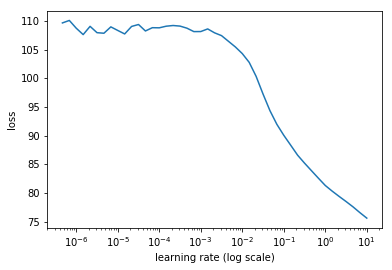

In [125]:
m.lr_find(start_lr=1e-8, end_lr=100)
m.sched.plot()

In [126]:
lr=1e-2

In [128]:
m.fit(lr, 10, metrics=[rmsle])

epoch      trn_loss   val_loss   rmsle                     
    0      2.628136   2.785346   1.664719  
    1      2.559312   2.763831   1.657467                  
    2      2.460758   2.737891   1.649687                  
    3      2.338282   2.63748    1.62107                   
    4      2.191261   2.680136   1.632863                  
    5      2.1484     2.71872    1.645655                  
    6      2.055813   2.760928   1.655967                  
    7      2.018859   2.734179   1.650393                  
    8      1.981223   2.666088   1.628446                  
    9      1.924717   2.755246   1.651645                  



[2.755246102809906, 1.6516454655279051]

In [129]:
m.fit(lr, 3, metrics=[rmsle], cycle_len=2)

epoch      trn_loss   val_loss   rmsle                     
    0      1.846508   2.674579   1.633051  
    1      1.70903    2.757484   1.658465                  
    2      1.736226   2.803976   1.672372                  
    3      1.619332   2.771854   1.662724                  
    4      1.686253   2.803825   1.671924                  
    5      1.603618   2.79815    1.66935                   



[2.7981495459874473, 1.6693504005892585]

In [114]:
m.fit(lr, 2, metrics=[rmsle], cycle_len=4)

epoch      trn_loss   val_loss   rmsle                     
    0      2.023285   2.598347   1.609904  
    1      2.023014   2.727258   1.64731                   
    2      1.825987   2.755126   1.656442                  
    3      1.683871   2.792634   1.667299                  
    4      1.778463   3.046253   1.741506                  
    5      1.834863   2.568055   1.601397                  
    6      1.721297   2.722462   1.648865                  
    7      1.573864   2.741907   1.654763                  



[2.7419071197509766, 1.6547627445688555]

In [115]:
m.save('val0')

# test and submit

In [116]:
m.load('val0')

In [117]:
x,y=m.predict_with_targs()

In [118]:
rmsle(x,y)

1.6621266598368651

In [119]:
pred_test=m.predict(True)

In [120]:
pred_test = np.exp(pred_test) - 1

create submission file

In [121]:
submission = pd.read_csv(f'{PATH}/sample_submission.csv')

In [122]:
submission['target'] = pred_test

In [123]:
submission[['ID','target']].to_csv(f'{PATH}/sample_submission.csv', index=False)